# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


In [0]:
!pip install pydrive
!pip install gensim
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1cZS7OUXVft4KTZ1AzZPu95hSgWzu3aC8'}) # replace the id with id of file you want to access
downloaded.GetContentFile('final.sqlite')

In [0]:
# loading libraries and data

%matplotlib inline

import sqlite3                          # for sql database
import pandas as pd
import numpy as np
import nltk                             # nltk:- Natural Language Processing Toolkit
import string
import re
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import pickle
def saveindisk(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def openfromdisk(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

con = sqlite3.connect("final.sqlite")

# Filtering only positive and negative reviews that is
# not taking into consideration those reviews with score = 3
df = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con)

In [8]:
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [9]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [10]:
df.shape

(364171, 13)

In [11]:
df['Score'].size

364171

In [12]:
# Taking Sample Datapoints
n_samples = 15000
df_sample = df.sample(n_samples)
df_sample.sort_values('Time', inplace=True) #Sorting with respect to time
df_sample.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
169258,212449,230260,B00004RYGX,A2HIZRVOKXKZ52,KAY N. FOWLER,0,0,Positive,1012780800,Beetlejuice - Great Fun for Everyone!,When vacationing Adam and Barbara Maitland mee...,b'vacat adam barbara maitland meet demis kill ...,b'vacationing adam barbara maitland meet demis...
128153,152809,165717,B0000D9N59,A59DU8EGS1QNU,Ryan Cardone,15,20,Positive,1068422400,The Cheese Served In Heaven,This amazingly flavored cheese was at the top ...,b'amaz flavor chees top food triangl throughou...,b'amazingly flavored cheese top food triangle ...
110280,128419,139366,B0000CGDUK,AU1N8A8XWHHTP,"J. Wright ""Super Dad""",35,35,Positive,1068508800,The Real Deal!,This is the real deal people. This is real Ja...,b'real deal peopl real jamaican coffe brand cl...,b'real deal people real jamaican coffee brands...
178039,224637,243579,B0000DIYKD,AYHW6HJSUCSAE,"""insolent_shoeshine_grrl""",11,13,Positive,1072656000,Fantastic Real Licorice From The Land Down Under,I recently purchased a bag of Kookaburra Black...,b'recent purchas bag kookaburra black licoric ...,b'recently purchased bag kookaburra black lico...
255133,347552,375943,B0000DBN1L,APWF2542427ZF,Raj,8,9,Positive,1072742400,Tazo Chai,This is Awesome!! Tastes like its a complex ho...,b'awesom tast like complex home mixtur spice e...,b'awesome tastes like complex home mixture spi...


In [0]:
# Function to split train and test set by time

def train_test_split_by_time(X, y, test_ratio = 0.3):
    """
    y parameter needs to be a pandas series
    with timestamp as its index
    """
    
    train_ratio = 1 - test_ratio
    train_end = int(train_ratio * len(y))
    
    sorted_index = y.index.argsort()
    train_index = sorted_index[:train_end]
    test_index = sorted_index[train_end:]
    
    try:
        return X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]
    except KeyError:
        # if X is a pandas data structure
        return X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

In [0]:
# function to perform grid-search
def GridSearch(clf, param_grid, X, y, test_size=0.3, cv=10, n_jobs=-1,
                 random_search=False, n_iter=10, return_train_score=False):
    """
    Splits the data using time based slicing
    Performs grid search to search for optimal parameter
    using exaustive or random search
    Print accuracy and classification report with
    best parameter on test set
    """
    
    # time based splitting of dataset
    X_train, X_test, y_train, y_test = train_test_split_by_time(X, y, test_size)
    
    if random_search:
        grid_search = RandomizedSearchCV(clf, param_grid, n_iter=n_iter, 
                                         n_jobs=n_jobs, verbose=1, cv=cv, 
                                         return_train_score=return_train_score)
    else:
        grid_search = GridSearchCV(clf, param_grid, n_jobs=n_jobs, 
                                   verbose=1, cv=cv, 
                                   return_train_score=return_train_score)
    
    print('Performing grid search...\n')
    print('Parameters:')
    print(param_grid)
    print()
    
    grid_search.fit(X_train, y_train)
    print('\n')
    
    print("Best CV score: %f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("\nTest score with best_estimator_: %f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n              Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    
    return grid_search

# Applying the KNN Models on the different Vectorizing Techniques


## Bag of Word(BOW)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [16]:
bi_gram = CountVectorizer(min_df=10)
bi_gram_vectors = bi_gram.fit_transform(df_sample['CleanedText'])
bi_gram_vectors.shape

(15000, 3468)

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split_by_time(bi_gram_vectors,df_sample['Score'])

In [19]:
# Train model with default hyperparameter
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [22]:
y_pred = clf.predict(X_test)

print('Accuracy on test set:', accuracy_score(y_test, y_pred))
print('\n                    Classification Report')
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.8997777777777778

                    Classification Report
             precision    recall  f1-score   support

   Negative       0.69      0.66      0.67       700
   Positive       0.94      0.94      0.94      3800

avg / total       0.90      0.90      0.90      4500



## Searching optimal alpha for MultinomialNB

In [32]:
param_grid = {'alpha': 10.0 ** np.arange(-4, 5)}

best_alpha = GridSearch(clf, param_grid, bi_gram_vectors, df_sample['Score'])

Performing grid search...

Parameters:
{'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])}

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished




Best CV score: 0.896095
Best parameters set:
	alpha: 0.1

Test score with best_estimator_: 0.898889

              Classification Report Test Data
             precision    recall  f1-score   support

   Negative       0.70      0.62      0.66       700
   Positive       0.93      0.95      0.94      3800

avg / total       0.89      0.90      0.90      4500



## Observation
*Naive Bayes model is giving a good accuracy of 90%* 

## Confusion matrix

In [0]:
def plot_confusion_matrix_(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
    # convert to percentage
    df_cm = df_cm.divide(df_cm.sum(axis=1), axis='index') * 100
    sns.heatmap(df_cm, annot=True, fmt='.1f');
    plt.show()

In [0]:
pred = clf.predict(X_test)

In [49]:
y_test

254010    Positive
254025    Positive
254107    Positive
254141    Positive
254145    Positive
254200    Positive
254201    Positive
254220    Positive
254243    Positive
254263    Positive
254274    Positive
254275    Positive
254277    Positive
254296    Positive
254322    Positive
254357    Positive
254377    Negative
254400    Positive
254412    Negative
254438    Positive
254445    Positive
254481    Positive
254492    Positive
254494    Positive
254499    Positive
254516    Positive
254547    Negative
254580    Positive
254587    Positive
254592    Positive
            ...   
363502    Positive
363509    Positive
363526    Positive
363531    Positive
363539    Positive
363582    Positive
363612    Positive
363629    Negative
363643    Positive
363675    Positive
363684    Positive
363777    Positive
363807    Positive
363814    Positive
363850    Positive
363884    Negative
363888    Positive
363921    Positive
363937    Positive
363989    Positive
364013    Positive
364016    Po

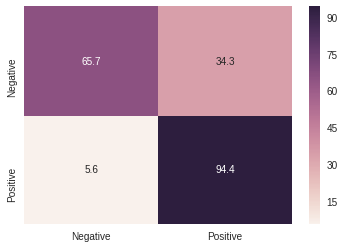

In [53]:
plot_confusion_matrix_(y_test, pred, labels=['Negative', 'Positive'])


* From confusion matrix we can say that missclassification is 5.6% of positvie reviews and 34.3% of negative reviews are classified as positive reviews

## Feature Importance

In [0]:
word = {v: k for (k, v) in bi_gram.vocabulary_.items()}

neg_prob = [(word[i], np.exp(prob)) for (i, prob) in enumerate(clf.feature_log_prob_[0])]
pos_prob = [(word[i], np.exp(prob)) for (i, prob) in enumerate(clf.feature_log_prob_[1])]
pos_prob = pd.DataFrame.from_records(pos_prob, columns=['word', 'log_prob']).sort_values('log_prob', ascending=False)
neg_prob = pd.DataFrame.from_records(neg_prob, columns=['word', 'log_prob']).sort_values('log_prob', ascending=False)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


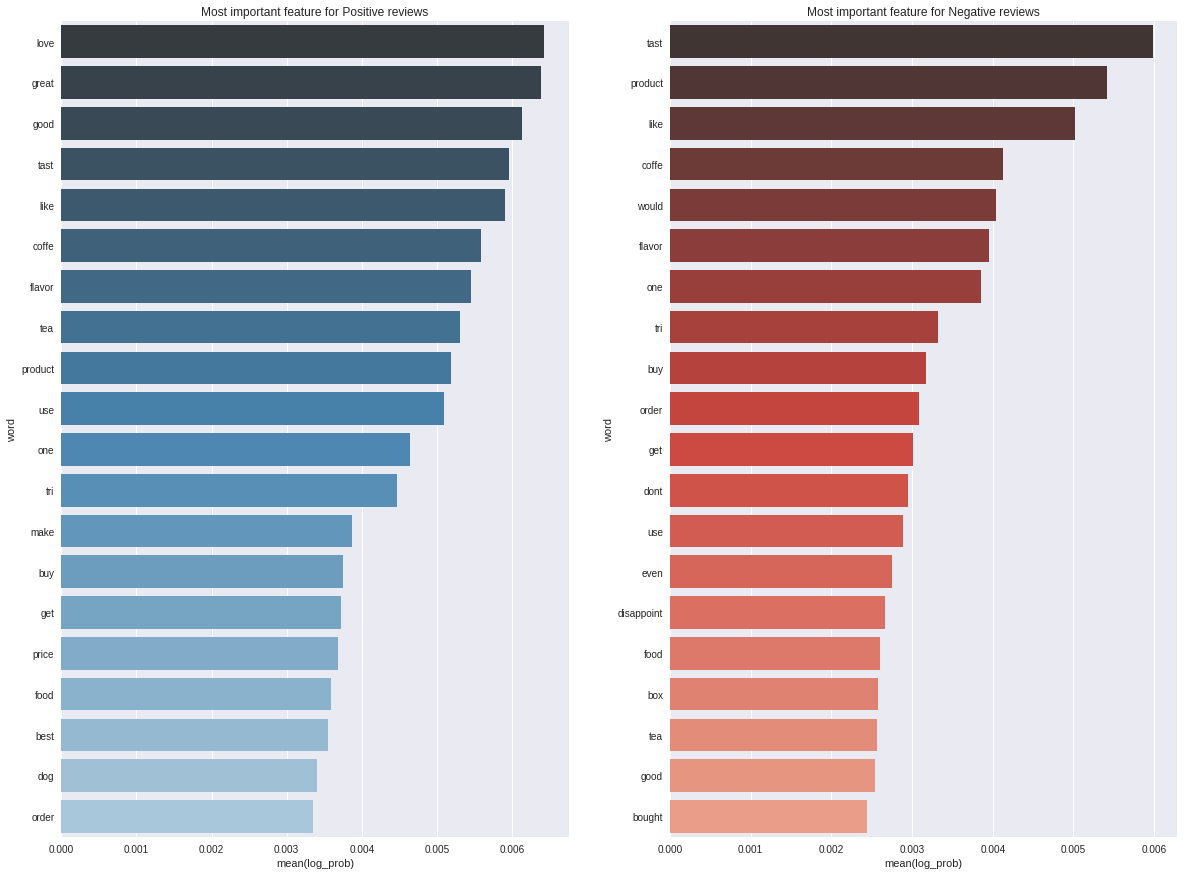

In [73]:
fig, ax =plt.subplots(1,2, figsize=(20,15))

sns.barplot(x='log_prob', y='word', data=pos_prob.head(20), palette='Blues_d', ax=ax[0])
ax[0].set_title('Most important feature for Positive reviews')


sns.barplot(x='log_prob', y='word', data=neg_prob.head(20), palette='Reds_d', ax=ax[1])
ax[1].set_title('Most important feature for Negative reviews');

# tf-idf

TFIDF = TF x IDF

In [0]:
tfidf = TfidfVectorizer(min_df=10) 
tfidf_vectors = tfidf.fit_transform(df_sample['CleanedText'].values)

In [0]:
# spliting data into train and test
X_train, X_test, y_train, y_test = train_test_split_by_time(tfidf_vectors,df_sample['Score'])

In [64]:
# Train model with default hyperparameter
clf = MultinomialNB()
clf.fit(X_train, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [65]:
y_pred = clf.predict(X_test)

print('Accuracy on test set:', accuracy_score(y_test, y_pred))
print('\n                    Classification Report')
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.8595555555555555

                    Classification Report
             precision    recall  f1-score   support

   Negative       0.95      0.10      0.19       700
   Positive       0.86      1.00      0.92      3800

avg / total       0.87      0.86      0.81      4500



## Searching optimal alpha for MultinomialNB

In [66]:
param_grid = {'alpha': 10.0 ** np.arange(-4, 5)}

best_alpha = GridSearch(clf, param_grid, bi_gram_vectors, df_sample['Score'])

Performing grid search...

Parameters:
{'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])}

Fitting 10 folds for each of 9 candidates, totalling 90 fits


Best CV score: 0.896095
Best parameters set:
	alpha: 0.1

Test score with best_estimator_: 0.898889

              Classification Report Test Data
             precision    recall  f1-score   support

   Negative       0.70      0.62      0.66       700
   Positive       0.93      0.95      0.94      3800

avg / total       0.89      0.90      0.90      4500



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


## Confusion matrix

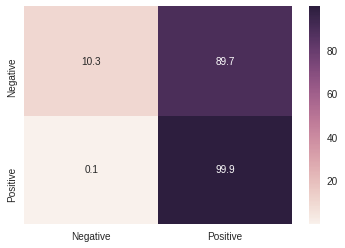

In [67]:
pred = clf.predict(X_test)
plot_confusion_matrix_(y_test, pred, labels=['Negative', 'Positive'])


* From confusion matrix we can say that missclassification is 0.1% of positvie reviews and 89.7% of negative reviews are classified as positive reviews

## Feature Importance

In [0]:
id2word = {v: k for (k, v) in tfidf.vocabulary_.items()}

neg_prob = [(id2word[i], np.exp(prob)) for (i, prob) in enumerate(clf.feature_log_prob_[0])]
pos_prob = [(id2word[i], np.exp(prob)) for (i, prob) in enumerate(clf.feature_log_prob_[1])]
pos_prob = pd.DataFrame.from_records(pos_prob, columns=['word', 'log_prob']).sort_values('log_prob', ascending=False)
neg_prob = pd.DataFrame.from_records(neg_prob, columns=['word', 'log_prob']).sort_values('log_prob', ascending=False)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


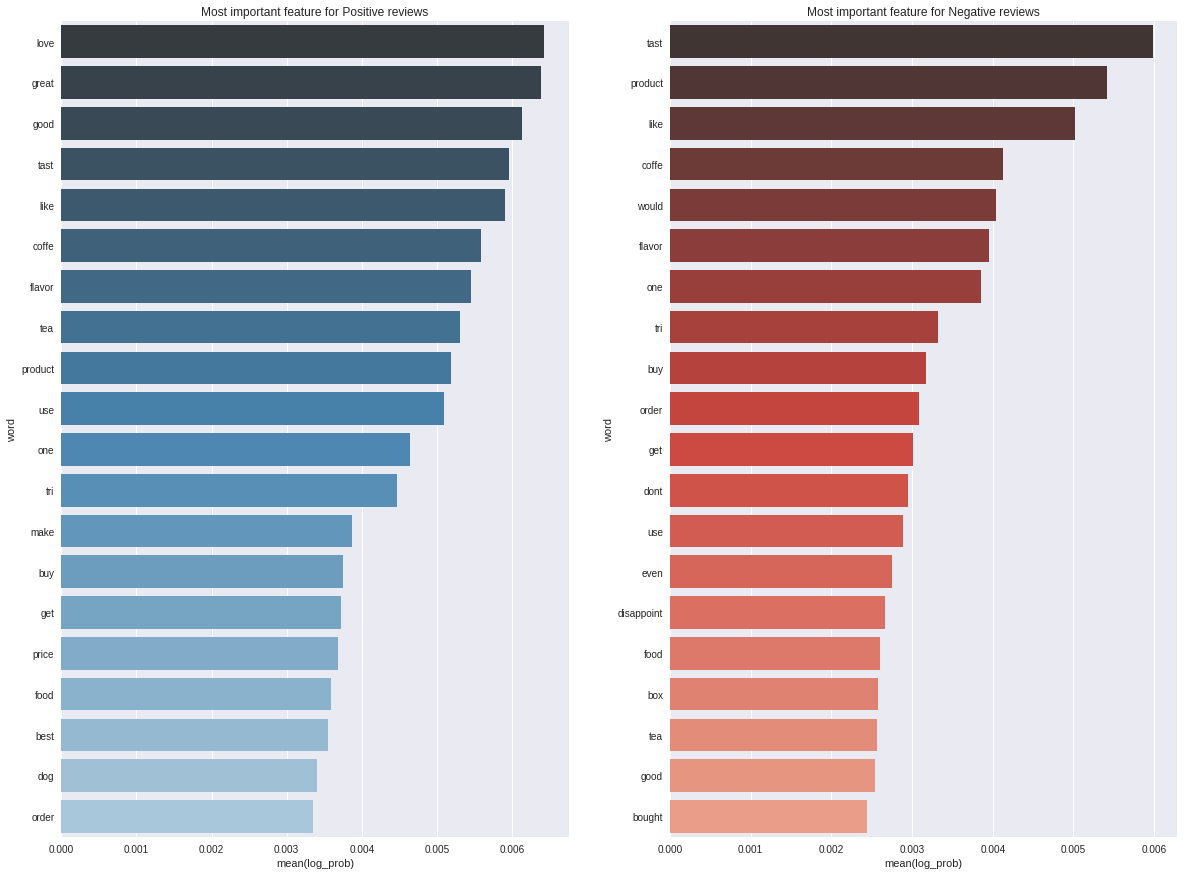

In [70]:
fig, ax =plt.subplots(1,2, figsize=(20,15))

sns.barplot(x='log_prob', y='word', data=pos_prob.head(20), palette='Blues_d', ax=ax[0])
ax[0].set_title('Most important feature for Positive reviews')


sns.barplot(x='log_prob', y='word', data=neg_prob.head(20), palette='Reds_d', ax=ax[1])
ax[1].set_title('Most important feature for Negative reviews');

# Word2Vec
* Word2Vec vectors sometimes contain negative values, whereas Naive Bayes is only compatible with positive values.

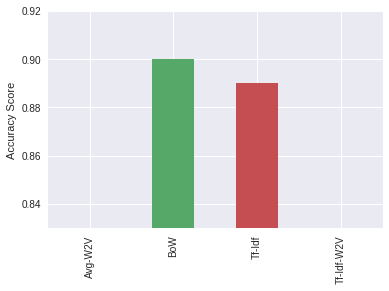

In [74]:
nb_model_accuracy = {
    'BoW': 0.900,
    'Tf-Idf': 0.890,
    'Avg-W2V': np.nan,
    'Tf-Idf-W2V': np.nan
}

pd.Series(nb_model_accuracy).plot(kind='bar')
plt.ylabel('Accuracy Score')
plt.ylim((0.83, 0.92));

# Conclusion:-
* Naive Bayes gives very good accuracy compared to the knn classification.